<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Dask Array

<img src="images/DaskArray.png" width="50%" align="right">
Dask array provides a parallel, larger-than-memory, n-dimensional array using blocked algorithms. Simply put: distributed Numpy.

*  **Parallel**: Uses all of the cores on your computer
*  **Larger-than-memory**:  Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
*  **Blocked Algorithms**:  Perform large computations by performing many smaller computations



### Common Uses
Dask Array is used in fields like atmospheric and oceanographic science, large scale imaging, genomics, numerical algorithms for optimization or statistics, and more.

### Scope
Dask arrays support most of the NumPy interface like the following:

- Arithmetic and scalar mathematics: +, *, exp, log, ...
- Reductions along axes: sum(), mean(), std(), sum(axis=0), ...
- Tensor contractions / dot products / matrix multiply: tensordot
- Axis reordering / transpose: transpose
- Slicing: x[:100, 500:100:-2]
- Fancy indexing along single axes with lists or NumPy arrays: x[:, [10, 1, 5]]
- Array protocols like __array__ and __array_ufunc__
- Some linear algebra: svd, qr, solve, solve_triangular, lstsq

However, Dask Array does not implement the entire NumPy interface. Users expecting this will be disappointed. Notably, Dask Array lacks the following features:

- Much of np.linalg has not been implemented. This has been done by a number of excellent BLAS/LAPACK implementations, and is the focus of numerous ongoing academic research projects
- Arrays with unknown shapes do not support all operations
- Operations like sort which are notoriously difficult to do in parallel, and are of somewhat diminished value on very large data (you rarely actually need a full sort). Often we include parallel-friendly alternatives like topk
- Dask Array doesn’t implement operations like tolist that would be very inefficient for larger datasets. Likewise, it is very inefficient to iterate over a Dask array with for loops
- Dask development is driven by immediate need, hence many lesser used functions have not been implemented. Community contributions are encouraged

## Best Practices
It is easy to get started with Dask arrays, but using them well does require some experience. 
Below are few suggestions for best practices, and includes solutions to common problems.

#### Use NumPy
If your data fits comfortably in RAM and you are not performance bound, then using NumPy might be the right choice. Dask adds another layer of complexity which may get in the way.

If you are just looking for speedups rather than scalability then you may want to consider a project like **Numba**.

#### Select a good chunk size
A common performance problem among Dask Array users is that they have chosen a chunk size that is either too small (leading to lots of overhead) or poorly aligned with their data (leading to inefficient reading).

While optimal sizes and shapes are highly problem specific, it is rare to see chunk sizes below 100 MB in size. If you are dealing with float64 data then this is around (4000, 4000) in size for a 2D array or (100, 400, 400) for a 3D array.

You want to choose a chunk size that is large in order to reduce the number of chunks that Dask has to think about (which affects overhead) but also small enough so that many of them can fit in memory at once. Dask will often have as many chunks in memory as twice the number of active threads.

#### Orient your chunks
When reading data you should align your chunks with your storage format. Most array storage formats store data in chunks themselves. If your Dask array chunks aren’t multiples of these chunk shapes then you will have to read the same data repeatedly, which can be expensive. Note though that often storage formats choose chunk sizes that are much smaller than is ideal for Dask, closer to 1MB than 100MB. In these cases you should choose a Dask chunk size that aligns with the storage chunk size and that every Dask chunk dimension is a multiple of the storage chunk dimension.



## Chunks
Dask arrays are composed of many NumPy arrays. How these arrays are arranged can significantly affect performance. For example, for a square array you might arrange your chunks along rows, along columns, or in a more square-like fashion. Different arrangements of NumPy arrays will be faster or slower for different algorithms.

Thinking about and controlling chunking is important to optimize advanced algorithms.

#### Specifying Chunk shapes
We always specify a chunks argument to tell dask.array how to break up the underlying array into chunks. We can specify chunks in a variety of ways:

- A uniform dimension size like 1000, meaning chunks of size 1000 in each dimension
- A uniform chunk shape like (1000, 2000, 3000), meaning chunks of size 1000 in the first axis, 2000 in the second axis, and 3000 in the third
- Fully explicit sizes of all blocks along all dimensions, like ((1000, 1000, 500), (400, 400), (5, 5, 5, 5, 5))
- A dictionary specifying chunk size per dimension like {0: 1000, 1: 2000, 2: 3000}. This is just another way of writing the forms 2 and 3 above

Your chunks input will be normalized and stored in the third and most explicit form. Note that chunks stands for **“chunk shape”** rather than **“number of chunks”**, so specifying chunks=1 means that you will have many chunks, each with exactly one element.

### For performance, a good choice of chunks follows the following rules:

- A chunk should be small enough to fit comfortably in memory. We’ll have many chunks in memory at once.

- A chunk must be large enough so that computations on that chunk take significantly longer than the 1ms overhead per task that Dask scheduling incurs. A task should take longer than 100ms.

- Chunk sizes between 10MB-1GB are common, depending on the availability of RAM and the duration of computations.

- Chunks should align with the computation that you want to do.

For example, if you plan to frequently slice along a particular dimension, then it’s more efficient if your chunks are      aligned so that you have to touch fewer chunks. If you want to add two arrays, then its convenient if those arrays have matching chunks patterns

- Chunks should align with your storage, if applicable.

Array data formats are often chunked as well. When loading or saving data, if is useful to have Dask array chunks that are aligned with the chunking of your storage, often an even multiple times larger in each direction

### Visualize task graphs

Before executing your computation you might consider visualizing the underlying task graph. By looking at the inter-connectedness of tasks you can learn more about potential bottlenecks where parallelism may not be possile, or areas where many tasks depend on each other, which may cause a great deal of communication.

The ``.visualize`` method and ``dask.visualize`` function work exactly like the ``.compute`` method and ``dask.compute`` function, except that rather than computing the result, they produce an image of the task graph.

By default the task graph is rendered from top to bottom. In the case that you prefer to visualize it from left to right, pass rankdir="LR" as a keyword argument to .visualize.

In [2]:
import dask.array as da
x = da.ones((15, 15), chunks=(5, 5))

y = x + x.T

# y.compute()
y.visualize(filename='transpose.svg')``

<img src="images/transpose.svg">

Note that the visualize function is powered by the `GraphViz` system library. This library has a few considerations:

- You must install both the graphviz system library (with tools like apt-get, yum, or brew) and the graphviz Python library. If you use Conda then you need to install python-graphviz, which will bring along the graphviz system library as a dependency.
- Graphviz takes a while on graphs larger than about 100 nodes. For large computations you might have to simplify your computation a bit for the visualize method to work well.

### Examples

#### Using Numpy

In [19]:
#Performing Matrix multiplication 
import numpy as np 
import time
start=time.time()
#A 2-dimensional array of size 3 x 3, composed of 2-byte integer elements:
x = np.array([[1, 2, 3], [4, 5, 6],[7, 8, 9]])
#A 3-dimensional array of size 3 x 3 x 3, composed of 2-byte integer elements:
y = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[10, 11, 12], [13, 14, 15], [16, 17, 18]],
                  [[10, 11, 12], [13, 14, 15], [16, 17, 18]]])
 # multiply()is used to multiply matrices
print ("Multiplication of two matrices: ")
print (np.multiply(x,y))
end=time.time()
print("Wall time:",end-start,"s")

Multiplication of two matrices: 
[[[  1   4   9]
  [ 16  25  36]
  [ 49  64  81]]

 [[ 10  22  36]
  [ 52  70  90]
  [112 136 162]]

 [[ 10  22  36]
  [ 52  70  90]
  [112 136 162]]]
Wall time: 0.0009987354278564453 s


#### Using Dask

In [24]:
import numpy as np
import dask.array as da
import time
start=time.time()
#A 2-dimensional array of size 3 x 3, composed of 2-byte integer elements:
x = da.array([[1, 2, 3], [4, 5, 6],[7, 8, 9]])
#A 3-dimensional array of size 3 x 3 x 3, composed of 2-byte integer elements:
a = da.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[10, 11, 12], [13, 14, 15], [16, 17, 18]],
                  [[10, 11, 12], [13, 14, 15], [16, 17, 18]]])
y = da.from_array(a,chunks=(1,3,3))
print ("Multiplication of two matrices: ")
print (da.multiply(x,y).compute())
end=time.time()
print("Wall time:",end-start,"s")

Multiplication of two matrices: 
[[[  1   4   9]
  [ 16  25  36]
  [ 49  64  81]]

 [[ 10  22  36]
  [ 52  70  90]
  [112 136 162]]

 [[ 10  22  36]
  [ 52  70  90]
  [112 136 162]]]
Wall time: 0.009993553161621094 s


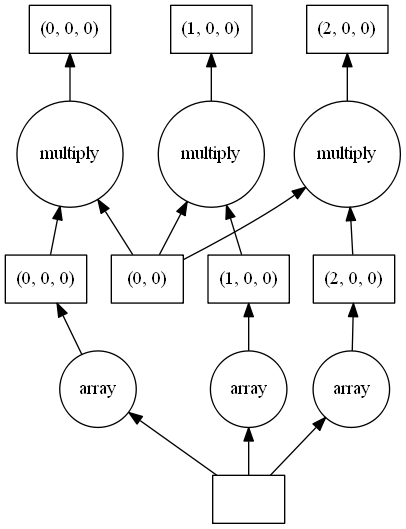

In [25]:
da.multiply(x,y).visualize()

### Random array

In [27]:
import dask.array as da
import time
import statistics
d_time = []
for i in range(1):
    start =time.time()
    #creating 2x2 random array
    x = da.random.random(2,2)
    #creating 10x2x2 random array
    y = da.random.random(size=(10, 2, 2), chunks=(4,2,2))
    
    print ("Multiplication of two matrices: ")
    print (da.multiply(x,y).compute())
    end = time.time()
    t = end-start

Multiplication of two matrices: 
[[[0.1348951  0.00965337]
  [0.0286169  0.04112959]]

 [[0.12726159 0.02234556]
  [0.03596023 0.08955904]]

 [[0.01999288 0.06532277]
  [0.04029045 0.08690193]]

 [[0.1358128  0.10611352]
  [0.11153025 0.00337657]]

 [[0.05459214 0.01120684]
  [0.10930522 0.06260745]]

 [[0.03794256 0.04657235]
  [0.00072582 0.01474077]]

 [[0.01583085 0.08312675]
  [0.05473533 0.03001983]]

 [[0.01814135 0.07028915]
  [0.00757087 0.08256151]]

 [[0.06977889 0.05773408]
  [0.04036122 0.02328067]]

 [[0.13568501 0.06215853]
  [0.04692465 0.04957078]]]
